In [1]:
import os
import cv2
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 80


In [2]:
import cv2
import numpy as np

def frames_extractor(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    for frame_counter in range(0, video_frames_count, skip_frames_window):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
        success, frame = video_reader.read()
        if not success:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

        if len(faces) > 0:
            x, y, w, h = faces[0]
            face = frame[y:y+h, x:x+w]
            resized_face = cv2.resize(face, (IMAGE_HEIGHT, IMAGE_WIDTH))
            normalized_face = resized_face / 255.0
            frames_list.append(normalized_face)
 
       # Stop if we have collected enough frames
        if len(frames_list) >= SEQUENCE_LENGTH:
            break

    video_reader.release()

    # Ensure the number of frames is equal to SEQUENCE_LENGTH
    while len(frames_list) < SEQUENCE_LENGTH:
        frames_list.append(np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH, 3)))  # Add empty frames if needed

    return frames_list


In [50]:
import os
import numpy as np

def create_dataset(root_dir, classes_list):
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(classes_list):
        class_dir = os.path.join(root_dir, class_name)
        
        files_list = os.listdir(class_dir)

        for file_name in files_list:
            video_file_path = os.path.join(class_dir, file_name)
            
            frames = frames_extractor(video_file_path)
            
            # Check if the extracted frames match the SEQUENCE_LENGTH
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    
    # Convert lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)
    
    return features, labels, video_files_paths

# Set your root directory and classes list
DATASET_DIR = "C:\\Users\\bhatt\\Machine Learning\\DeepTrace\\celebDataset"
CLASSES_LIST = ["real", "synthetic"]


features, labels, video_files_paths = create_dataset(DATASET_DIR, CLASSES_LIST)


In [51]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.25, shuffle=True)

features_train = torch.tensor(features_train).float().permute(0, 1, 4, 2, 3).to(device)  
features_test = torch.tensor(features_test).float().permute(0, 1, 4, 2, 3).to(device)
labels_train = torch.tensor(labels_train).long().to(device)
labels_test = torch.tensor(labels_test).long().to(device)

In [52]:
class VideoDataset(data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = VideoDataset(features_train, labels_train)
test_dataset = VideoDataset(features_test, labels_test)

train_loader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=4, shuffle=False)


In [53]:
import torch
import torch.nn as nn

class ConvLSTMModel(nn.Module):
    def __init__(self, num_classes):
        super(ConvLSTMModel, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2) 
        )
        
        cnn_output_size = 32 * (IMAGE_HEIGHT // 4) * (IMAGE_WIDTH // 4)
        self.lstm = nn.LSTM(input_size=cnn_output_size, hidden_size=64, batch_first=True)

        self.fc = nn.Linear(64 * SEQUENCE_LENGTH, num_classes)  # Update this based on LSTM hidden size

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.size()
        x = x.reshape(batch_size * seq_len, channels, height, width)
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.reshape(batch_size, seq_len, -1)
        lstm_out, _ = self.lstm(cnn_features)
        lstm_out = lstm_out.reshape(batch_size, -1)
        output = self.fc(lstm_out)
        return output


# Instantiate the model
num_classes = len(CLASSES_LIST)
convlstm_model = ConvLSTMModel(num_classes).to(device)


In [54]:
#MODEL TESTING
import torch

batch_size = 4  
sequence_length = 80  
channels = 3  
height = 64  
width = 64  

random_input = torch.rand(batch_size, sequence_length, channels, height, width)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
convlstm_model.to(device)

with torch.no_grad(): 
    convlstm_model.eval()  
    output = convlstm_model(random_input.to(device))

print("Output shape:", output.shape)  #Outpur should be BatchSize and Number of Classes


Output shape: torch.Size([4, 2])


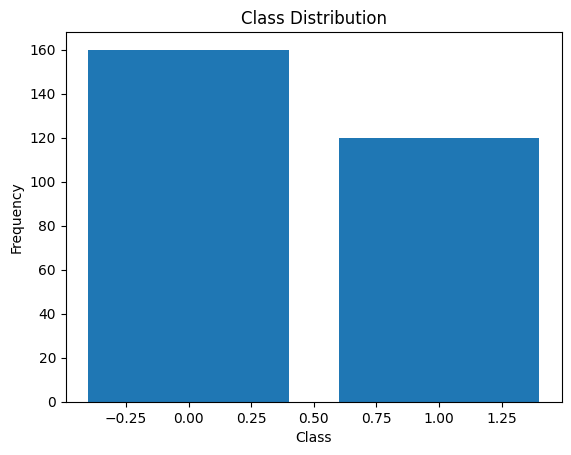

In [55]:
import matplotlib.pyplot as plt
import numpy as np

unique, counts = np.unique(labels, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()


In [64]:
# TRAINING

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

model = ConvModel(num_classes=len(CLASSES_LIST)).to(device)  # Ensure you're using the correct model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Create a progress bar with tqdm
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Get predictions
            _, predicted = outputs.max(1)
            total += labels.size(0)  # Update total here
            correct += (predicted == labels).sum().item()  # Count correct predictions

            # Update progress bar
            pbar.set_postfix(loss=running_loss/total, accuracy=100.*correct/total if total > 0 else 0)
            pbar.update(1)

    # Print loss and accuracy at the end of the epoch
    avg_loss = running_loss / len(train_loader)
    avg_accuracy = 100. * correct / total if total > 0 else 0  # Avoid division by zero
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%")


Epoch 1/50:   0%|          | 0/53 [00:00<?, ?batch/s]

Epoch 1/50: 100%|██████████| 53/53 [00:02<00:00, 19.81batch/s, accuracy=55.7, loss=0.174]


Epoch [1/50], Loss: 0.6882, Accuracy: 55.71%


Epoch 2/50: 100%|██████████| 53/53 [00:03<00:00, 17.29batch/s, accuracy=58.6, loss=0.169]


Epoch [2/50], Loss: 0.6712, Accuracy: 58.57%


Epoch 3/50: 100%|██████████| 53/53 [00:03<00:00, 13.77batch/s, accuracy=65.2, loss=0.165]


Epoch [3/50], Loss: 0.6547, Accuracy: 65.24%


Epoch 4/50: 100%|██████████| 53/53 [00:04<00:00, 12.79batch/s, accuracy=64.8, loss=0.157]


Epoch [4/50], Loss: 0.6221, Accuracy: 64.76%


Epoch 5/50: 100%|██████████| 53/53 [00:03<00:00, 14.87batch/s, accuracy=75.2, loss=0.149]


Epoch [5/50], Loss: 0.5888, Accuracy: 75.24%


Epoch 6/50: 100%|██████████| 53/53 [00:04<00:00, 12.61batch/s, accuracy=77.6, loss=0.14] 


Epoch [6/50], Loss: 0.5545, Accuracy: 77.62%


Epoch 7/50: 100%|██████████| 53/53 [00:04<00:00, 12.05batch/s, accuracy=75.7, loss=0.133]


Epoch [7/50], Loss: 0.5278, Accuracy: 75.71%


Epoch 8/50: 100%|██████████| 53/53 [00:04<00:00, 12.85batch/s, accuracy=74.3, loss=0.135]


Epoch [8/50], Loss: 0.5348, Accuracy: 74.29%


Epoch 9/50: 100%|██████████| 53/53 [00:04<00:00, 12.77batch/s, accuracy=79.5, loss=0.123]


Epoch [9/50], Loss: 0.4879, Accuracy: 79.52%


Epoch 10/50: 100%|██████████| 53/53 [00:04<00:00, 13.02batch/s, accuracy=81, loss=0.116]  


Epoch [10/50], Loss: 0.4594, Accuracy: 80.95%


Epoch 11/50: 100%|██████████| 53/53 [00:03<00:00, 15.27batch/s, accuracy=83.8, loss=0.111]


Epoch [11/50], Loss: 0.4387, Accuracy: 83.81%


Epoch 12/50: 100%|██████████| 53/53 [00:03<00:00, 17.41batch/s, accuracy=81.9, loss=0.111]


Epoch [12/50], Loss: 0.4382, Accuracy: 81.90%


Epoch 13/50: 100%|██████████| 53/53 [00:02<00:00, 18.52batch/s, accuracy=84.3, loss=0.111] 


Epoch [13/50], Loss: 0.4394, Accuracy: 84.29%


Epoch 14/50: 100%|██████████| 53/53 [00:02<00:00, 17.75batch/s, accuracy=84.8, loss=0.103] 


Epoch [14/50], Loss: 0.4097, Accuracy: 84.76%


Epoch 15/50: 100%|██████████| 53/53 [00:02<00:00, 17.70batch/s, accuracy=85.7, loss=0.101] 


Epoch [15/50], Loss: 0.4012, Accuracy: 85.71%


Epoch 16/50: 100%|██████████| 53/53 [00:03<00:00, 15.83batch/s, accuracy=85.7, loss=0.0979]


Epoch [16/50], Loss: 0.3878, Accuracy: 85.71%


Epoch 17/50: 100%|██████████| 53/53 [00:03<00:00, 16.74batch/s, accuracy=86.7, loss=0.0943]


Epoch [17/50], Loss: 0.3735, Accuracy: 86.67%


Epoch 18/50: 100%|██████████| 53/53 [00:03<00:00, 17.51batch/s, accuracy=86.2, loss=0.0913]


Epoch [18/50], Loss: 0.3616, Accuracy: 86.19%


Epoch 19/50: 100%|██████████| 53/53 [00:03<00:00, 17.37batch/s, accuracy=86.2, loss=0.0949]


Epoch [19/50], Loss: 0.3760, Accuracy: 86.19%


Epoch 20/50: 100%|██████████| 53/53 [00:03<00:00, 16.52batch/s, accuracy=87.1, loss=0.0893]


Epoch [20/50], Loss: 0.3537, Accuracy: 87.14%


Epoch 21/50: 100%|██████████| 53/53 [00:03<00:00, 15.08batch/s, accuracy=87.1, loss=0.09]  


Epoch [21/50], Loss: 0.3568, Accuracy: 87.14%


Epoch 22/50: 100%|██████████| 53/53 [00:03<00:00, 13.66batch/s, accuracy=90, loss=0.0931]  


Epoch [22/50], Loss: 0.3690, Accuracy: 90.00%


Epoch 23/50: 100%|██████████| 53/53 [00:03<00:00, 14.57batch/s, accuracy=86.7, loss=0.0835]


Epoch [23/50], Loss: 0.3310, Accuracy: 86.67%


Epoch 24/50: 100%|██████████| 53/53 [00:04<00:00, 12.63batch/s, accuracy=89, loss=0.0866]  


Epoch [24/50], Loss: 0.3430, Accuracy: 89.05%


Epoch 25/50: 100%|██████████| 53/53 [00:04<00:00, 12.89batch/s, accuracy=87.6, loss=0.0866]


Epoch [25/50], Loss: 0.3432, Accuracy: 87.62%


Epoch 26/50: 100%|██████████| 53/53 [00:03<00:00, 14.48batch/s, accuracy=91.4, loss=0.0856]


Epoch [26/50], Loss: 0.3393, Accuracy: 91.43%


Epoch 27/50: 100%|██████████| 53/53 [00:03<00:00, 13.83batch/s, accuracy=90, loss=0.082]   


Epoch [27/50], Loss: 0.3248, Accuracy: 90.00%


Epoch 28/50: 100%|██████████| 53/53 [00:03<00:00, 15.70batch/s, accuracy=91, loss=0.0795]  


Epoch [28/50], Loss: 0.3152, Accuracy: 90.95%


Epoch 29/50: 100%|██████████| 53/53 [00:02<00:00, 17.70batch/s, accuracy=89.5, loss=0.0837]


Epoch [29/50], Loss: 0.3315, Accuracy: 89.52%


Epoch 30/50: 100%|██████████| 53/53 [00:03<00:00, 13.79batch/s, accuracy=90.5, loss=0.0775]


Epoch [30/50], Loss: 0.3070, Accuracy: 90.48%


Epoch 31/50: 100%|██████████| 53/53 [00:04<00:00, 13.06batch/s, accuracy=89, loss=0.0768]  


Epoch [31/50], Loss: 0.3045, Accuracy: 89.05%


Epoch 32/50: 100%|██████████| 53/53 [00:04<00:00, 13.14batch/s, accuracy=87.6, loss=0.0819]


Epoch [32/50], Loss: 0.3244, Accuracy: 87.62%


Epoch 33/50: 100%|██████████| 53/53 [00:03<00:00, 13.60batch/s, accuracy=91.4, loss=0.0764]


Epoch [33/50], Loss: 0.3027, Accuracy: 91.43%


Epoch 34/50: 100%|██████████| 53/53 [00:04<00:00, 13.14batch/s, accuracy=89, loss=0.077]   


Epoch [34/50], Loss: 0.3051, Accuracy: 89.05%


Epoch 35/50: 100%|██████████| 53/53 [00:04<00:00, 12.57batch/s, accuracy=93.8, loss=0.0738]


Epoch [35/50], Loss: 0.2926, Accuracy: 93.81%


Epoch 36/50: 100%|██████████| 53/53 [00:04<00:00, 10.90batch/s, accuracy=93.3, loss=0.0701]


Epoch [36/50], Loss: 0.2776, Accuracy: 93.33%


Epoch 37/50: 100%|██████████| 53/53 [00:04<00:00, 12.88batch/s, accuracy=93.8, loss=0.069] 


Epoch [37/50], Loss: 0.2732, Accuracy: 93.81%


Epoch 38/50: 100%|██████████| 53/53 [00:04<00:00, 12.86batch/s, accuracy=91.4, loss=0.0796]


Epoch [38/50], Loss: 0.3154, Accuracy: 91.43%


Epoch 39/50: 100%|██████████| 53/53 [00:04<00:00, 13.08batch/s, accuracy=92.4, loss=0.0718]


Epoch [39/50], Loss: 0.2843, Accuracy: 92.38%


Epoch 40/50: 100%|██████████| 53/53 [00:04<00:00, 12.07batch/s, accuracy=92.9, loss=0.0689]


Epoch [40/50], Loss: 0.2729, Accuracy: 92.86%


Epoch 41/50: 100%|██████████| 53/53 [00:04<00:00, 12.58batch/s, accuracy=93.3, loss=0.0689]


Epoch [41/50], Loss: 0.2730, Accuracy: 93.33%


Epoch 42/50: 100%|██████████| 53/53 [00:04<00:00, 12.50batch/s, accuracy=92.4, loss=0.0733]


Epoch [42/50], Loss: 0.2905, Accuracy: 92.38%


Epoch 43/50: 100%|██████████| 53/53 [00:04<00:00, 12.07batch/s, accuracy=92.4, loss=0.0715]


Epoch [43/50], Loss: 0.2833, Accuracy: 92.38%


Epoch 44/50: 100%|██████████| 53/53 [00:04<00:00, 13.16batch/s, accuracy=92.4, loss=0.0685]


Epoch [44/50], Loss: 0.2713, Accuracy: 92.38%


Epoch 45/50: 100%|██████████| 53/53 [00:04<00:00, 11.57batch/s, accuracy=91.9, loss=0.0688]


Epoch [45/50], Loss: 0.2724, Accuracy: 91.90%


Epoch 46/50: 100%|██████████| 53/53 [00:04<00:00, 11.91batch/s, accuracy=93.3, loss=0.0659]


Epoch [46/50], Loss: 0.2613, Accuracy: 93.33%


Epoch 47/50: 100%|██████████| 53/53 [00:04<00:00, 12.80batch/s, accuracy=93.3, loss=0.069] 


Epoch [47/50], Loss: 0.2733, Accuracy: 93.33%


Epoch 48/50: 100%|██████████| 53/53 [00:04<00:00, 13.21batch/s, accuracy=93.3, loss=0.0635]


Epoch [48/50], Loss: 0.2515, Accuracy: 93.33%


Epoch 49/50: 100%|██████████| 53/53 [00:04<00:00, 12.30batch/s, accuracy=92.9, loss=0.0655]


Epoch [49/50], Loss: 0.2595, Accuracy: 92.86%


Epoch 50/50: 100%|██████████| 53/53 [00:04<00:00, 13.04batch/s, accuracy=92.9, loss=0.0712]

Epoch [50/50], Loss: 0.2823, Accuracy: 92.86%


In [65]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Accuracy: {100.*correct/total}%")

# Save the Model
torch.save(model.state_dict(), "ConvLSTM_Test3.h5")

Test Accuracy: 91.42857142857143%


Test Accuracy: 91.42857142857143%
Visualizing some predictions:


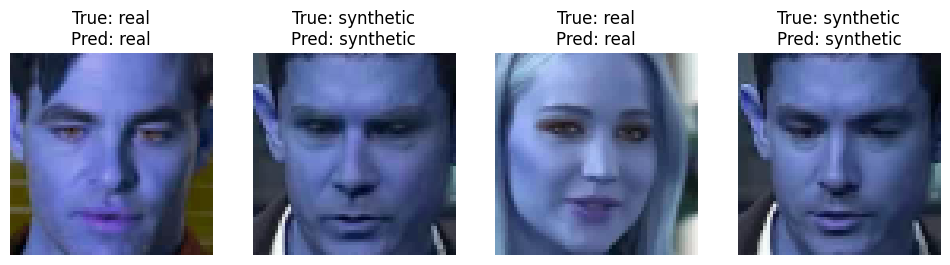

In [67]:
#VISUALISE
import matplotlib.pyplot as plt

# Function to test and visualize predictions
def test_and_visualize(model, test_loader, num_samples=4):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    # Randomly select some samples from the test set for visualization
    sample_inputs, sample_labels = next(iter(test_loader))

    with torch.no_grad():
        # Get predictions for the test set
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        print(f"Test Accuracy: {100.*correct/total}%")

    # Visualize the predictions
    print("Visualizing some predictions:")

    # Use sample_inputs for visualization
    model.eval()
    with torch.no_grad():
        sample_inputs = sample_inputs.to(device)
        sample_outputs = model(sample_inputs)
        _, predicted_labels = torch.max(sample_outputs, 1)

    # Converting back to CPU for visualization
    sample_inputs = sample_inputs.cpu().numpy()
    predicted_labels = predicted_labels.cpu().numpy()
    sample_labels = sample_labels.cpu().numpy()

    fig, axes = plt.subplots(1, num_samples, figsize=(12, 6))

    for i in range(num_samples):
        # Get the ith sequence of frames
        input_sequence = sample_inputs[i]
        true_label = sample_labels[i]
        pred_label = predicted_labels[i]

        # Take one frame from the sequence to visualize
        frame_to_display = input_sequence[0].transpose(1, 2, 0)  # Convert to HxWxC format

        axes[i].imshow(frame_to_display)
        axes[i].set_title(f"True: {CLASSES_LIST[true_label]}\nPred: {CLASSES_LIST[pred_label]}")
        axes[i].axis('off')

    plt.show()

# Call the function to test and visualize
test_and_visualize(model, test_loader, num_samples=4)


Confusion Matrix:
 [[35  6]
 [ 0 29]]
Classification Report:
               precision    recall  f1-score   support

        real       1.00      0.85      0.92        41
   synthetic       0.83      1.00      0.91        29

    accuracy                           0.91        70
   macro avg       0.91      0.93      0.91        70
weighted avg       0.93      0.91      0.91        70



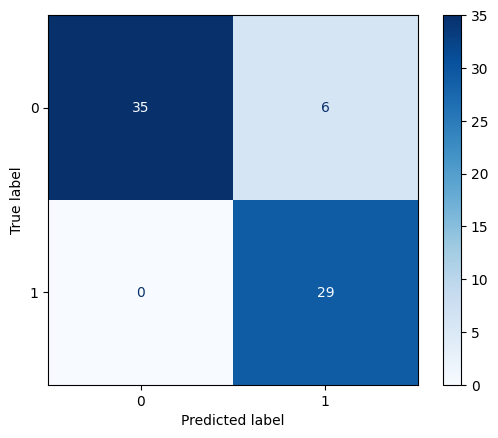

In [68]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Assuming you have the following:
# true_labels: actual labels from your dataset
# predictions: model predictions

def evaluate_model(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    return np.array(all_true_labels), np.array(all_predictions)

# Evaluate the model using your dataloader (e.g., validation or test set)
true_labels, predictions = evaluate_model(model, test_loader, device)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", cm)

# Display confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues')

# Classification report (includes precision, recall, F1-score)
report = classification_report(true_labels, predictions, target_names=CLASSES_LIST)
print("Classification Report:\n", report)



In [ ]:
import torch
import torchvision.transforms as transforms
import cv2
from PIL import Image

def load_model(model_path):
    model = ConvLSTMModel(num_classes=len(CLASSES_LIST))
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def frames_extractor(video_path, sequence_length):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)

    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

def preprocess_frames(frames):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])
    tensor_frames = [transform(Image.fromarray((frame * 255).astype('uint8'))) for frame in frames]
    return torch.stack(tensor_frames)

def test_model(model, video_tensor):
    with torch.no_grad():
        output = model(video_tensor)
        _, predicted = output.max(1)
    return predicted.item()

model_path = 'C:\\Users\\bhatt\\Machine Learning\\DeepTrace\\models\\ConvLSTM\\ConvLSTM_Test3.h5'
video_path = 'C:\\Users\\bhatt\\Machine Learning\\DeepTrace\\celebDataset\\synthetic\\id0_id1_0006.mp4'  # Replace with the path to your video

model = load_model(model_path)
frames = frames_extractor(video_path, SEQUENCE_LENGTH)

if len(frames) == SEQUENCE_LENGTH:
    video_tensor = preprocess_frames(frames).unsqueeze(0)  # Add batch dimension
    predicted_class = test_model(model, video_tensor)
    print(f'Predicted class: {predicted_class}')
else:
    print(f'Insufficient frames extracted: {len(frames)} (required: {SEQUENCE_LENGTH})')
